In [1]:
from scipy import stats
from matplotlib import pyplot as plt
import numpy as np
import math

In [2]:
def generate_sample(n, rnd):
    return [rnd() for _ in range(n)]

In [3]:
SAMPLE_SIZE = 3000

In [4]:
def plot_dfs(distr, distr_name, my_rnd, sample_name):
    sample = generate_sample(SAMPLE_SIZE, my_rnd)
    sample.sort()
    edf = np.arange(1, len(sample) + 1) / len(sample)

    x = np.linspace(min(sample) - 1, max(sample) + 1, 200)
    y = distr.cdf(x)
    plt.plot(x, y, label=distr_name, color='red')
    plt.plot(sample, edf, label=sample_name, color='blue')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title("Функция распределения")
    plt.legend()
    plt.grid(True)
    plt.show()

    y2 = distr.pdf(x)
    plt.plot(x, y2, label=distr_name, color='red')
    plt.hist(sample, bins=35, density=True, label=sample_name, color='blue')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title("Плотность")
    plt.legend()
    plt.grid(True)
    plt.show()


In [5]:
def check_as_norm(my_rnd, smaple_name):
    plot_dfs(stats.norm, "N(0, 1)", my_rnd, smaple_name)

Зафмксируем случайную величину $$X \sim Exp(4) $$

In [6]:
lambd = 4
expon = stats.expon(scale=1 / lambd)
samples = [generate_sample(SAMPLE_SIZE, expon.rvs) for _ in range(SAMPLE_SIZE)]
ind = 0
def get_sample():
    global ind
    res = samples[ind]
    ind += 1
    if ind == len(samples):
        ind = 0
    return res
    

# Sample Mean
Проверим асимптотическую нормальность выборочного среднего

Хотим проверить, что
$$\sqrt{n} (\hat{\alpha_1} - \alpha_1) \rightarrow^d U \sim N(0, \sigma^2)$$

Чему равна $\sigma$?

По ЦПТ
$$\sqrt{n} (\hat{\alpha_1} - \alpha_1) \rightarrow^d N(0, Var(X))$$

То есть сгенерируем `SAMPLE_SIZE` выборочных средних, постоим график получившейся эмпирической фнкции распределения, убедимся что он похож на ф.р. стандартного нормального распределения


In [7]:
mean_alpha = expon.mean()
mean_sigma = np.sqrt(expon.moment(2) - mean_alpha**2)

def sample_mean_normalized():
    alpha_hat = sum(get_sample()) / SAMPLE_SIZE
    return np.sqrt(SAMPLE_SIZE) * (alpha_hat - mean_alpha) / mean_sigma

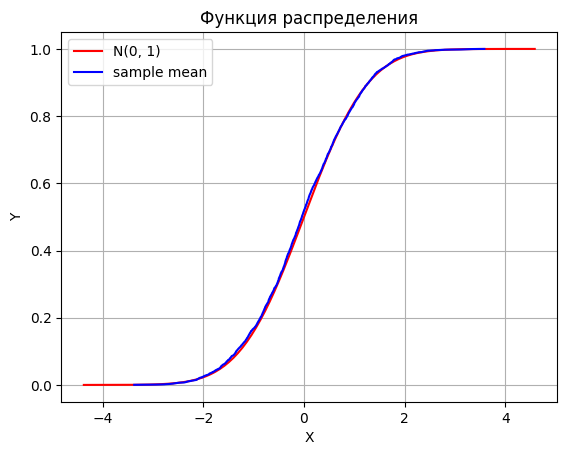

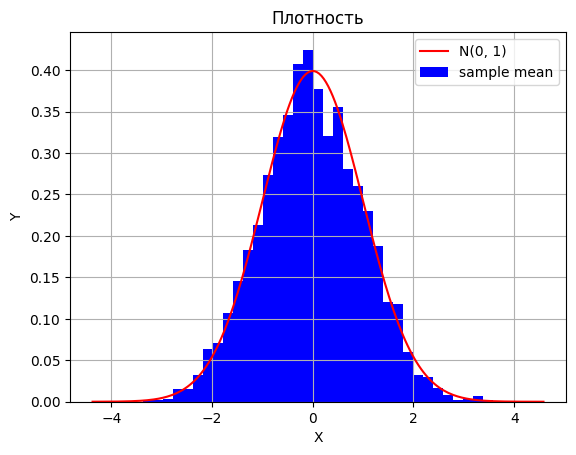

In [8]:
check_as_norm(sample_mean_normalized, "sample mean")

# Sample Variance

Проверим асимптотическую нормальность выборочной дисперсии $S_*^2$

Хотим проверить, что
$$\sqrt{n} (S_2^* - Var X) \ \rightarrow^d U \sim N(0, \sigma^2)$$

Чему равна $\sigma$ ?

Воспользуемся многомерной цпт для случайного вектора

$$Y = (\overline{X}, \overline{X^2})^T$$

$$E Y = \mu = (E X, E X^2) = (\frac{1}{\lambda}, \frac{2}{\lambda})$$

Т.к. моменты экспоненциального распределения $E x^n = \frac{n!}{\lambda^n}$

$E$

$$Var Y = \begin{pmatrix} Var X & Cov(X, X^2) \\ Cov(X, X^2) & Var X^2 \end{pmatrix} =
 \begin{pmatrix} \frac{1}{\lambda^2} & \frac{4}{\lambda^3} \\ \frac{4}{\lambda^3} & \frac{20}{\lambda} \end{pmatrix}$$

$$\sqrt{n} (Y - \mu) \rightarrow^d U \sim N(0, Var Y)$$

Теперь применим дельта метод к этому и функции $g(x_1, x_2) = x_2 - x_1^2$

$$\sqrt{n} (g(Y) - g(\mu)) \rightarrow U \sim N(0, \nabla g(\mu)(Var Y) \nabla g(\mu) ^T)$$

$$\nabla g(x_1, x_2) = (-2x_1, 1)$$

$$\nabla g(\mu)(Var Y) \nabla g(\mu) ^T = \frac{8}{\lambda^4}$$

Получаем

$$\sqrt{n} (S_2^* - Var Y) \rightarrow^d U \sim N(0, \frac{8}{\lambda^4})$$








In [9]:
beta2 = expon.var()
beta_delim = np.sqrt(8 / lambd ** 4)

def sample_variance_normalized():
    sample = get_sample()
    s = sum(sample) / SAMPLE_SIZE
    beta2_hat = sum([(i - s)**2 for i in sample]) / SAMPLE_SIZE
    return np.sqrt(SAMPLE_SIZE) * (beta2_hat - beta2) / beta_delim

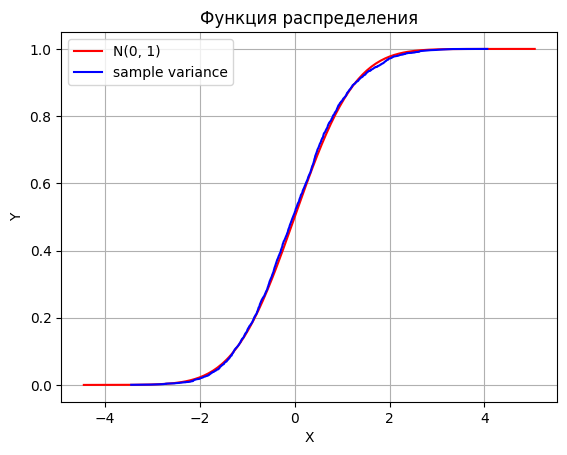

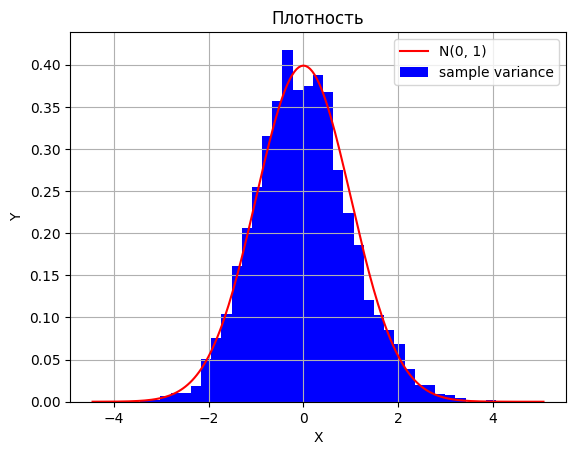

In [10]:
check_as_norm(sample_variance_normalized, "sample variance")

# SAMPLE QUANTILE 1/2

Проверим асимптотическую нормальность выборочной квантили порядка 0.5

Теоретический квантиль - $q_{p} = -\frac{\ln{(1 - p)}}{\lambda} \Rightarrow q_{0.5} = \frac{\ln{2}}{\lambda}$

Хотим проверить, что $$\sqrt{n} (\hat{q}_{0.5} - q_{0.5}) \rightarrow^d U \sim N(0, \sigma^2) $$

Чему же равна $\sigma$?

По теореме об асимптотике средних членов вариационного ряда.

$$\sqrt{n} \frac{\hat{q}_{0.5} - q_{0.5}}{\sqrt{p(1-p)}} f(q_p) \rightarrow^d U \sim N(0, 1) $$

Следовательно $\sigma = \frac{p(1-p)}{f^2(q_p)}$

Где $f$ - плотность


In [11]:
p = 1/2
q_half = np.log(2) / lambd

sigma = p*(1 - p)/(expon.pdf(q_half)**2)

def sample_quantile_normalized():
    sample = get_sample()
    sample.sort()
    return np.sqrt(SAMPLE_SIZE) * (sample[math.ceil(SAMPLE_SIZE * p)] - q_half) / np.sqrt(sigma)

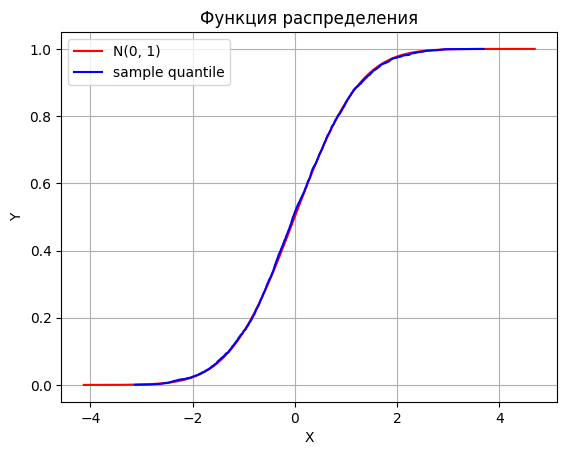

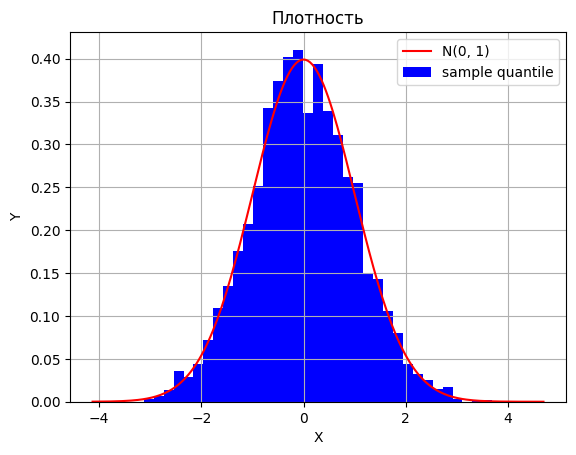

In [12]:
check_as_norm(sample_quantile_normalized, "sample quantile")

# Асимптотика крайних членов ряда

## Второй минимум

Хотим проверить, что $$n F(X_{(2)}) \rightarrow U_1 \sim \Gamma(2, 1)$$

In [13]:
def second_min():
    sample = get_sample()
    sample.sort()
    return SAMPLE_SIZE * expon.cdf(sample[1])

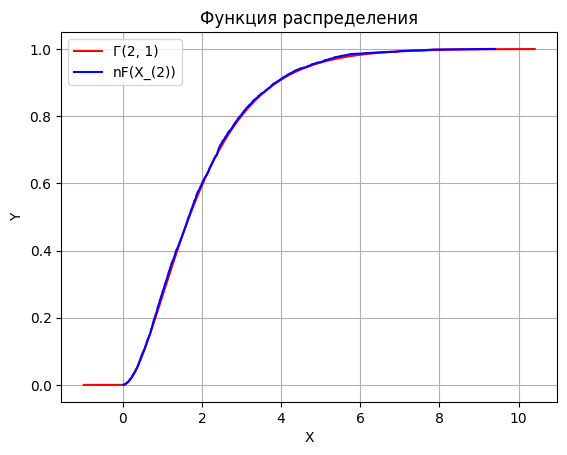

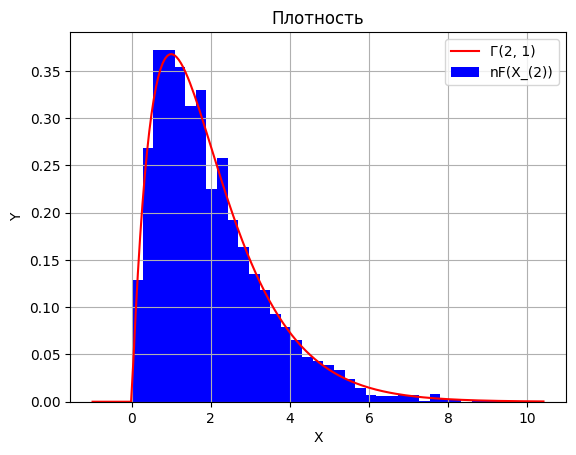

In [14]:
plot_dfs(stats.gamma(a=2), "Г(2, 1)", second_min, "nF(X_(2))")

Хотим проверить что

$$n (1 - F(X_{(n-2)}) \rightarrow U \sim \Gamma(3, 1)$$


In [15]:
def second_max():
    sample = get_sample()
    sample.sort()
    return SAMPLE_SIZE * (1 - expon.cdf(sample[-3]))

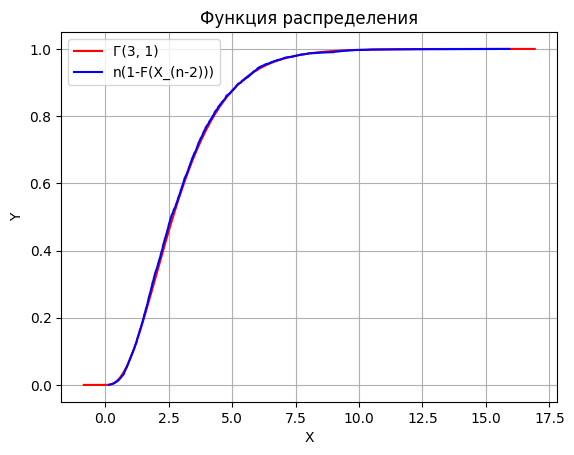

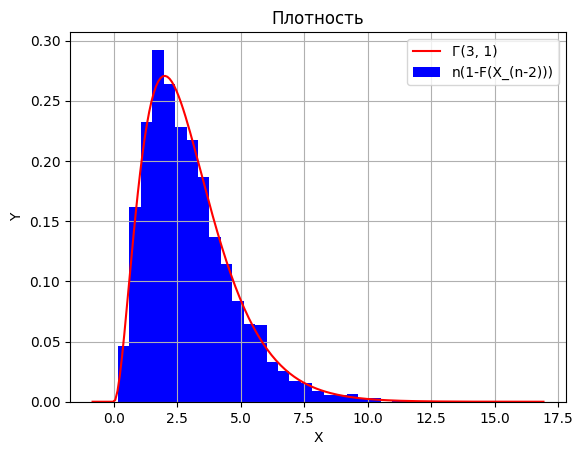

In [16]:
plot_dfs(stats.gamma(a=3), "Г(3, 1)", second_max, "n(1-F(X_(n-2)))")

Судя по графикам все распределения совпали с ожидаемыми (насколько можно судить визуально).